In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import init
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adagrad
from sklearn.metrics import accuracy_score

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(128, 48),
        nn.Softplus(),
        nn.BatchNorm1d(48),
        nn.Linear(48, 24),
        nn.Softplus(),
        nn.BatchNorm1d(24),
        nn.Linear(24, 10)
    )
    self._initialize_weights()

  def forward(self, x):
    return self.net(x)

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, a=0, nonlinearity='linear')
        init.constant_(m.bias, 0)

In [ ]:
def train(model, epochs, train_loader, criterion, optimizer):
  loss_list = []
  for epoch in tqdm(range(epochs)):
    total_loss = 0
    for x, y in train_loader:
      if torch.cuda.is_available():
        device = torch.device('cuda')
        x, y = x.to(device), y.to(device)
      optimizer.zero_grad()
      p = model(x)
      loss = criterion(p, y)
      total_loss += loss.item()
      loss.backward()
      optimizer.step()
    avg_loss = total_loss / len(train_loader)
    loss_list.append(avg_loss)
  return loss_list

In [ ]:
def accuracy(model, data_loader):
  model.eval()
  labels = []
  preds = []
  with torch.no_grad():
    for x, y in data_loader:
      if torch.cuda.is_available():
        device = torch.device('cuda')
        x, y = x.to(device), y.to(device)
      logits = model(x)
      _, p = torch.max(logits.data, 1)
      labels.extend(y.cpu().numpy())
      preds.extend(p.cpu().numpy())
  labels = np.array(labels)
  preds = np.array(preds)
  model.train()
  return accuracy_score(labels, preds)

In [ ]:
X_train = np.load("./data/train_data.npy")
y_train = np.load("./data/train_label.npy")
X_test = np.load("./data/test_data.npy")
y_test = np.load("./data/test_label.npy")
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long()
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long()
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
model = MLP()
epochs = 500
criterion = nn.CrossEntropyLoss()
optimizer = Adagrad(model.parameters(), lr=1e-3)
loss = train(model, epochs, train_loader, criterion, optimizer)

100%|██████████| 500/500 [21:11<00:00,  2.54s/it]


Accuracy on training set: 47.25%
Accuracy on validation set: 45.58%
Loss: 1.5270


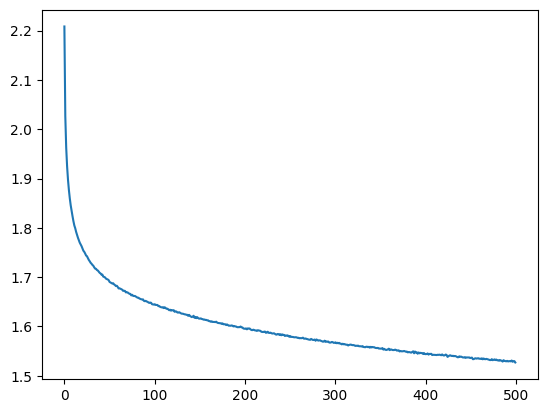

In [ ]:
print("Accuracy on training set: {:.2f}%".format(accuracy(model, train_loader)*100))
print("Accuracy on validation set: {:.2f}%".format(accuracy(model, test_loader)*100))
print("Loss: {:.4f}".format(loss[-1]))
plt.plot(loss)